In [1]:
import sys
import numpy
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
from scipy.ndimage import label
import numpy as np
import ast
from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap
import corner

def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None;
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [2]:
event_component_colors = {
    "GW190917_1": "#000000",  # black
    "GW190917_2": "#fa8072",  # salmon
    "GW230529_1": "#1e90ff",  # dodgerblue
    "GW190814_2": "#daa520",  # goldenrod
    "GW190425_2": "#87CEEB",  # skyblue
    "GW190425_1": "#228B22",  # forestgreen
    "GW200105_1": "#008080",  # teal
    "GW200105_2": "#8a2be2",  # blueviolet
    "GW200115_2": "#708090",  # slate grey
}

pop_parameter2latex = {"beta_1":r"$\beta_{\mathrm{low}}^\mathrm{NS}$",
                       "mu_peak_NS":r"$\mu^{\mathrm{peak}}_{\mathrm{NS}}$",
                       "sig_peak_NS":r"$\sigma^{\mathrm{peak}}_{\mathrm{NS}}$",
                       "mu_costilt":r"$\mu_{\mathrm{tilt}}$",
                       "mu_chi1":r"$\mu_{\chi}$"}

In [3]:
import os
import glob
import re
import pandas as pd
from tqdm import tqdm

def to_df(mmms_folder_name, pop_parameter, verbose = False):
    # Define pattern to match values from lines
    prob_pattern_pop = r"Probability: P\(mass <= max_mass\(spin, eos\)\) = ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"
    odds_pattern_pop = r"Odds Ratio\s*:.*= ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"

    prob_pattern_np = prob_pattern_pop
    odds_pattern_np = odds_pattern_pop

    prob_pattern_eos = r"Probability: P\(.*?\) = ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"
    odds_pattern_eos = r"Odds Ratio\s*:.*?= ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"


    # Create list to hold parsed data
    data = []

    # Loop through all .out files
    glob_path = f"../{mmms_folder_name}/*.out"
    for filepath in glob.glob(glob_path):

        if re.search(r"EOS", filepath):
            prob_pattern = prob_pattern_eos
            odds_pattern = odds_pattern_eos 
        elif re.search(r"non-parametric", filepath):
            prob_pattern = prob_pattern_np
            odds_pattern = odds_pattern_np 
        else:
            prob_pattern = prob_pattern_pop
            odds_pattern = odds_pattern_pop 


        with open(filepath, "r") as f:
            content = f.read()
            prob_match = re.search(prob_pattern, content)
            odds_match = re.search(odds_pattern, content)

            if prob_match and odds_match:
                prob, prob_err = map(float, prob_match.groups())
                odds, odds_err = map(float, odds_match.groups())
                data.append({
                    "filename": filepath,
                    "probability": prob,
                    "prob_error": prob_err,
                    "odds_ratio": odds,
                    "odds_error": odds_err
                })
            else:
                if verbose:
                    print(f"Warning: Could not parse values from {filepath}")

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)
    
    # Wrangle more
    df[pop_parameter] = df["filename"].str.extract(fr"{pop_parameter}\+(-?[\d.]+)").astype(float)
    df["event"] = df["filename"].str.extract(r"(GW\d+)")
    df["component"] = df["filename"].str.extract(r"component(\d+)").astype(int)
    return df

def simple_grid_plot(df, pop_parameter):
    GW190917_m1 = df[(df['event'] == "GW190917") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190917_m2 = df[(df['event'] == "GW190917") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW230529_m1 = df[(df['event'] == "GW230529") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190814_m2 = df[(df['event'] == "GW190814") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m1 = df[(df['event'] == "GW190425") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m2 = df[(df['event'] == "GW190425") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m1 = df[(df['event'] == "GW200105") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m2 = df[(df['event'] == "GW200105") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200115_m2 = df[(df['event'] == "GW200115") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    plt.figure()
    objects_lst = [GW230529_m1, GW190814_m2, GW190917_m2, GW190917_m1, GW190425_m2, GW190425_m1, GW200105_m2, GW200105_m1, GW200115_m2]
    objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    objects_colors = [ plt.get_cmap("nipy_spectral")(i / (len(objects_lst) - 1)) for i in range(len(objects_lst))]

    for i in range(len(objects_lst)):
        curr = objects_lst[i]
        curr_name = objects_names[i]
        p05 = curr["probability"] - curr["prob_error"] * 2
        p95 = curr["probability"] + curr["prob_error"] * 2
        if i == len(objects_lst) - 1:
            lab = "95\% CI"
        else:
            lab = None
        plt.plot(curr[pop_parameter], curr["probability"], label=curr_name, color = objects_colors[i])
        plt.fill_between(curr[pop_parameter], p05, p95, color="grey", alpha=0.2, label=lab)

    plt.ylabel("P(NS)")
    plt.xlabel(f"{pop_parameter}")
    plt.utkarshWrapper()
    plt.show()

In [4]:
import json

with open("folder2pop_parameter.json", "r") as f:
    folder2pop_parameter = json.load(f)

In [5]:
folders = [f for f in os.listdir("../") if os.path.isdir(os.path.join("../", f)) and f.startswith("grid")]
label_lst = [f[len("grid")+1:] for f in folders]
exclude_lst = ["gamma_low_debug", "plots", "mmms_plot_gamma_low", "mu_cos_tilt_debug", "mmms_plot_beta_low"]

# exclude_lst.append("mu_chi1_EOS") # Run in progress
# exclude_lst.append("sigma_chi_EOS") # Run in progress

df_lst = []

for label in tqdm(label_lst):
    if label in exclude_lst:
        df = pd.DataFrame()
        df_lst.append(df)
        continue

    pop_parameter = folder2pop_parameter[label]

    df = to_df(f"grid_{label}", pop_parameter)

    # Check if pop_parameter column exists
    if pop_parameter not in df.columns:
        print(f"[ERROR] Dataframe with {label} is missing the column '{pop_parameter}'")
        display(df)
        break

    # Ensure dataframe does not have None's in them
    # Check if any item in the DataFrame is None
    has_none = (df.isnull().values.any() or (df == None).values.any())
    if has_none:
        print(f"[ERROR] Dataframe with {label} has None values in it")
        display(df)
        break

    df_lst.append(df)
    pop_parameter = None

results = dict(zip(label_lst, df_lst))

results_serializable = {k: v.to_dict(orient="list") for k, v in results.items()}
with open("results.json", "w") as f:
    json.dump(results_serializable, f, indent=2)

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [01:31<00:00,  2.13s/it]


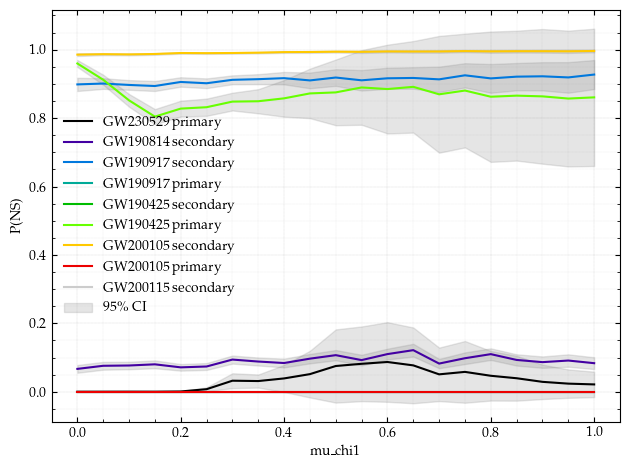

In [6]:
item = "mu_chi1_EOS"
simple_grid_plot(results[item], folder2pop_parameter[item])

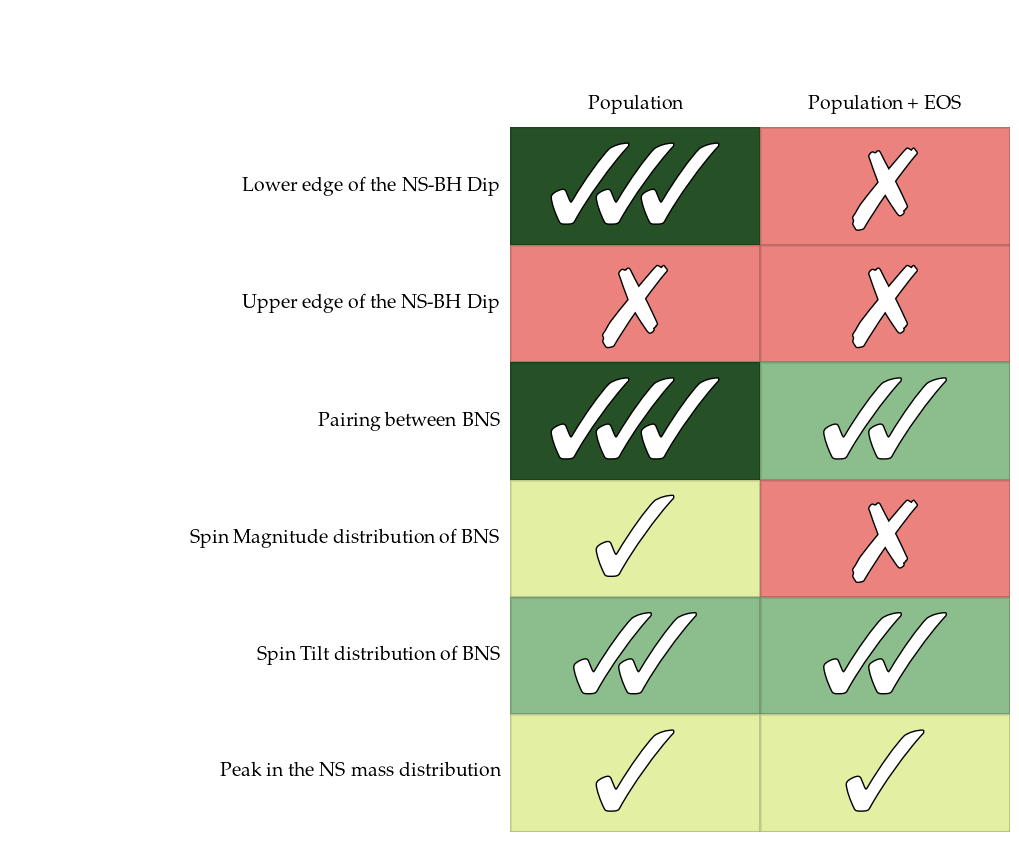

In [7]:
# Matrix grid: text + color box with tick/crosses, with title row and LaTeX/Unicode support
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as patheffects
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

plt.rcParams['text.latex.preamble'] = r"\usepackage{amssymb, pifont, wasysym, xcolor}"


tick = r'\ding{51}'
cross = r'\ding{55}'

_gamma_low = "Lower edge of the NS-BH Dip"
_gamma_high = "Upper edge of the NS-BH Dip" 
# _beta_low =  
_beta_low_NS = "Pairing between BNS" 
_mu_sigma = "Spin Magnitude distribution of BNS"
_mu_costilt =  "Spin Tilt distribution of BNS"
# _sig_costilt =  
_mu_peak_NS = "Peak in the NS mass distribution"
# _sig_peak_NS = 
_amax = "Maximum value of NS Spin"

row_labels = [_gamma_low, _gamma_high, _beta_low_NS,_mu_sigma, _mu_costilt, _mu_peak_NS]

# 0: cross, 1: one tick, 2: two ticks, 3: three ticks
col_pop = [3, 0, 3, 1, 2, 1]
col_eos = [0, 0, 2, 0, 2, 1]

# Color and symbol logic
# 0: cross, red; 1: one tick, yellow; 2: two ticks, green; 3: three ticks, very dark green
color_map = {
    0: ("#EB827D", cross),           # red
    1: ("#E3F0A3", tick),           # yellow
    2: ("#8CBD8C", tick),           # green
    3: ("#265126", tick)            # very dark green
}

nrows = len(row_labels)
fig = plt.figure(figsize=(10, 1.2 * (nrows + 1)))
gs = gridspec.GridSpec(nrows + 1, 3, width_ratios=[2, 1, 1], wspace=0.0, hspace=0.0)  # wspace=0.0, hspace=0.0 for touching

TEXT_SIZE = 14
SIZE = 80
Y = 0.4
SPACING = 0.18
FONT = "Arial"

# Title row 
ax_title0 = fig.add_subplot(gs[0, 0])
# ax_title0.text(0.5, 0.5, "Feature", ha='center', va='center', fontsize=10, fontweight='bold')
ax_title0.axis('off')
ax_title1 = fig.add_subplot(gs[0, 1])
ax_title1.text(0.5, 0.2, "Population", ha='center', va='center', fontsize=TEXT_SIZE, fontweight='bold')
ax_title1.axis('off')
ax_title2 = fig.add_subplot(gs[0, 2])
ax_title2.text(0.5, 0.2, "Population + EOS", ha='center', va='center', fontsize=TEXT_SIZE, fontweight='bold')
ax_title2.axis('off')

# Data rows
for i, label in enumerate(row_labels):
    # First column: text 
    ax0 = fig.add_subplot(gs[i + 1, 0])
    ax0.text(0.98, 0.5, label, ha='right', va='center', fontsize=TEXT_SIZE)
    ax0.axis('off')
    # Second column: color box with ticks/cross 
    ax1 = fig.add_subplot(gs[i + 1, 1])
    color, symbol = color_map[col_pop[i]]
    rect1 = Rectangle((0, 0), 1, 1, color=color, alpha=0.85,
                      path_effects=[patheffects.withStroke(linewidth=6, foreground='black', alpha=0.3),
                                    patheffects.withStroke(linewidth=2, foreground='black', alpha=0.7)])
    ax1.add_patch(rect1)
    # Fuzzy black outline
    rect1_outline = Rectangle((0, 0), 1, 1, fill=False, linewidth=0.1, edgecolor='black',
                              path_effects=[patheffects.withStroke(linewidth=0.1, foreground='black', alpha=0.5)])
    ax1.add_patch(rect1_outline)
    if col_pop[i] == 0:
        ax1.text(0.5, Y, cross, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    else:
        for t in range(col_pop[i]):
            ax1.text(0.5 + (t-((col_pop[i]-1)/2))*SPACING, Y, tick, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    # Third column: color box with ticks/cross 
    ax2 = fig.add_subplot(gs[i + 1, 2])
    color, symbol = color_map[col_eos[i]]
    rect2 = Rectangle((0, 0), 1, 1, color=color, alpha=0.85,
                      path_effects=[patheffects.withStroke(linewidth=6, foreground='black', alpha=0.3),
                                    patheffects.withStroke(linewidth=2, foreground='black', alpha=0.7)])
    ax2.add_patch(rect2)
    # Fuzzy black outline
    rect2_outline = Rectangle((0, 0), 1, 1, fill=False, linewidth=0.1, edgecolor='black',
                              path_effects=[patheffects.withStroke(linewidth=0.1, foreground='black', alpha=0.5)])
    ax2.add_patch(rect2_outline)
    if col_eos[i] == 0:
        ax2.text(0.5, Y, cross, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    else:
        for t in range(col_eos[i]):
            ax2.text(0.5+ (t-((col_eos[i]-1)/2))*SPACING, Y, tick, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

# Restore original 
plt.tight_layout(pad=0)
plt.savefig("plots/results_matrix.png", dpi = 300)
plt.show()

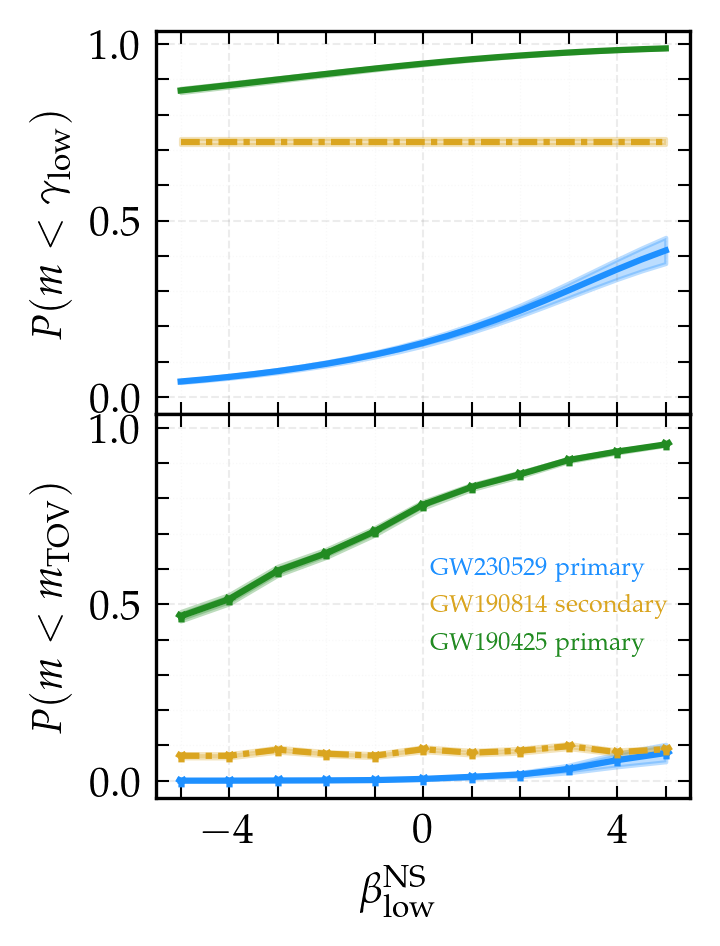

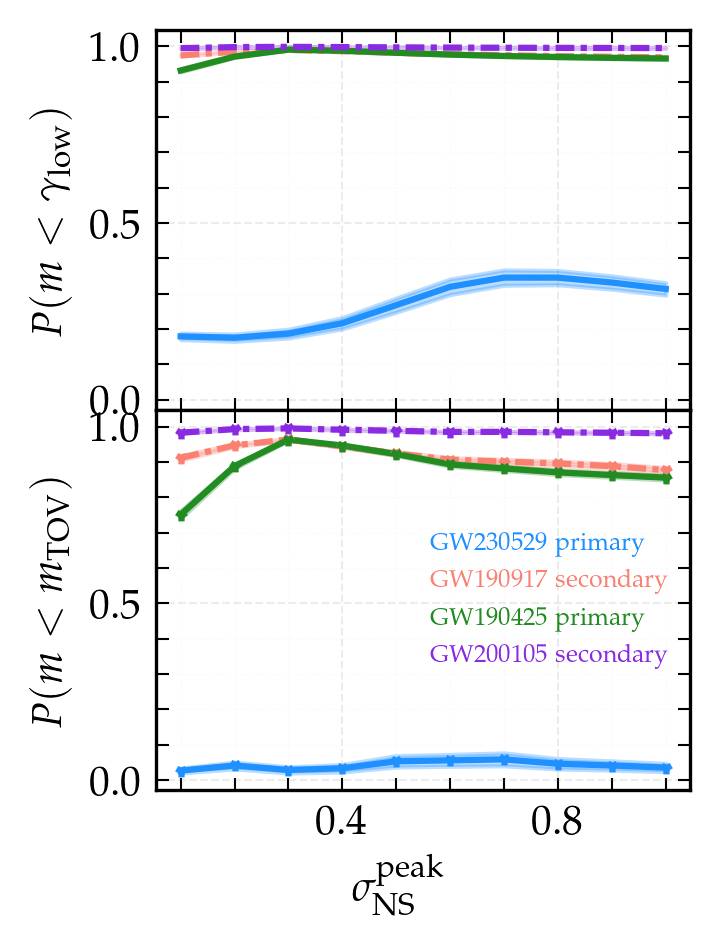

In [8]:
def key_to_name(tag):
    event, comp = tag.split("_")
    role = "primary" if comp == "1" else "secondary"
    return f"{event} {role}"

def name_to_key(name):
    # name example: "GW190917 primary"
    event = name.split()[0]
    comp = "1" if "primary" in name else "2"
    return f"{event}_{comp}"

def eos_pop_grid(df_pop, df_eos, pop_parameter, exclude_events = []):
    pop_GW190917_m1 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190917_m2 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW230529_m1 = df_pop[(df_pop['event'] == "GW230529") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190814_m2 = df_pop[(df_pop['event'] == "GW190814") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m1 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m2 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m1 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m2 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200115_m2 = df_pop[(df_pop['event'] == "GW200115") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_objects_lst = [pop_GW230529_m1, pop_GW190814_m2, pop_GW190917_m2, pop_GW190917_m1, pop_GW190425_m2, pop_GW190425_m1, pop_GW200105_m2, pop_GW200105_m1, pop_GW200115_m2]
    pop_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    pop_objects_colors = [event_component_colors[name_to_key(name)] for name in pop_objects_names]

    eos_GW190917_m1 = df_eos[(df_eos['event'] == "GW190917") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190917_m2 = df_eos[(df_eos['event'] == "GW190917") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW230529_m1 = df_eos[(df_eos['event'] == "GW230529") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190814_m2 = df_eos[(df_eos['event'] == "GW190814") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190425_m1 = df_eos[(df_eos['event'] == "GW190425") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190425_m2 = df_eos[(df_eos['event'] == "GW190425") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200105_m1 = df_eos[(df_eos['event'] == "GW200105") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200105_m2 = df_eos[(df_eos['event'] == "GW200105") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200115_m2 = df_eos[(df_eos['event'] == "GW200115") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_objects_lst = [eos_GW230529_m1, eos_GW190814_m2, eos_GW190917_m2, eos_GW190917_m1, eos_GW190425_m2, eos_GW190425_m1, eos_GW200105_m2, eos_GW200105_m1, eos_GW200115_m2]
    eos_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    eos_objects_colors = [event_component_colors[name_to_key(name)] for name in eos_objects_names]


    exclude_labels = set(key_to_name(e) for e in exclude_events)
    # === Filter population lists
    pop_keep_idxs = [i for i, name in enumerate(pop_objects_names) if name not in exclude_labels]
    pop_objects_lst = [pop_objects_lst[i] for i in pop_keep_idxs]
    pop_objects_names = [pop_objects_names[i] for i in pop_keep_idxs]
    pop_is_primary = [s.split()[-1].lower() == 'primary' for s in pop_objects_names]
    pop_objects_colors = [pop_objects_colors[i] for i in pop_keep_idxs]

    # === Filter EOS lists
    eos_keep_idxs = [i for i, name in enumerate(eos_objects_names) if name not in exclude_labels]
    eos_objects_lst = [eos_objects_lst[i] for i in eos_keep_idxs]
    eos_objects_names = [eos_objects_names[i] for i in eos_keep_idxs]
    eos_objects_colors = [eos_objects_colors[i] for i in eos_keep_idxs]

    height = 3.375  # inches
    width = 2.5  
    FONTSIZE = 10

    fig = plt.figure(figsize=(width, height), dpi=300)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0)

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    # === Plot population objects ===
    for i, curr in enumerate(pop_objects_lst):
        curr_name = pop_objects_names[i]
        is_primary = pop_is_primary[i]
        p05 = curr["probability"] - 1.28 * curr["prob_error"]
        p95 = curr["probability"] + 1.28 * curr["prob_error"]
        lab = "95\% CI" if i == len(pop_objects_lst) - 1 else None

        if is_primary:
            linestyle = "solid"
        else:
            linestyle = (0, (3, 1, 1, 1))

        ax0.plot(curr[pop_parameter], curr["probability"], label=curr_name, color=pop_objects_colors[i], linestyle=linestyle)
        ax0.fill_between(curr[pop_parameter], p05, p95, color=pop_objects_colors[i], alpha=0.3, label=lab)

    # === Plot EOS objects ===
    for i, curr in enumerate(eos_objects_lst):
        curr_name = eos_objects_names[i]
        is_primary = pop_is_primary[i]
        p05 = curr["probability"] - 1.28 * curr["prob_error"]
        p95 = curr["probability"] + 1.28 * curr["prob_error"]
        lab = "95\% CI" if i == len(eos_objects_lst) - 1 else None
        
        if is_primary:
            linestyle = "solid"
        else:
            linestyle = (0, (3, 1, 1, 1))

        ax1.plot(curr[pop_parameter], curr["probability"], label=curr_name, color=eos_objects_colors[i], linestyle=linestyle)
        ax1.scatter(curr[pop_parameter], curr["probability"], color=eos_objects_colors[i], s=8, zorder=3, marker = "1")
        ax1.fill_between(curr[pop_parameter], p05, p95, color=eos_objects_colors[i], alpha=0.3, label=lab)

    # === Share y-axis ===
    ax1.sharey(ax0)

    # === Format axes ===
    for ax in [ax0, ax1]:
        ax.tick_params(
            direction='in',       # Ticks inward
            top=True,             # Show top ticks
            right=True,           # Show right ticks
            which='both',         # Major and minor ticks
            length=3, width=0.5
        )

    for ax in [ax0, ax1]:
        ax.minorticks_on()
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.15)
        ax.grid(which='minor', axis='both', color='gray', linestyle=':', linewidth=0.3, alpha=0.05)

    # Remove y-axis labels and ticks on right plot
    # ax1.tick_params(labelleft=False)
    # ax1.set_ylabel("")
    

    # Shared x and y labels
    if pop_parameter in pop_parameter2latex:
        pop_lab = rf'{pop_parameter2latex[pop_parameter]}' 
    else:
        pop_lab = f"{pop_parameter}"

    fig.supxlabel(pop_lab, y=0.08, x = 0.55, fontsize=FONTSIZE)
    ax0.set_ylabel(r'$P(m < \gamma_{\mathrm{low}})$', fontsize=FONTSIZE)
    ax1.set_ylabel(r'$P(m < m_{\mathrm{TOV}})$', fontsize=FONTSIZE)

    # ax1.legend()
    legend_elements_eos = [
    Line2D([0], [0], label=label, color='none')
    for label in eos_objects_names
    ]
    legend = ax1.legend(handles=legend_elements_eos, loc='center right', fontsize=6, frameon=False)
    for text, color in zip(legend.get_texts(), eos_objects_colors):
        text.set_color(color)

    # Adjust layout to accommodate supxlabel
    plt.tight_layout()  # leave room for xlabel

item = "beta_low_NS"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1", "GW190917_2"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

item = "sig_peak_NS"
exclude_events = ["GW190814_2", "GW200105_1", "GW200115_2", "GW190917_1", "GW190425_2"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

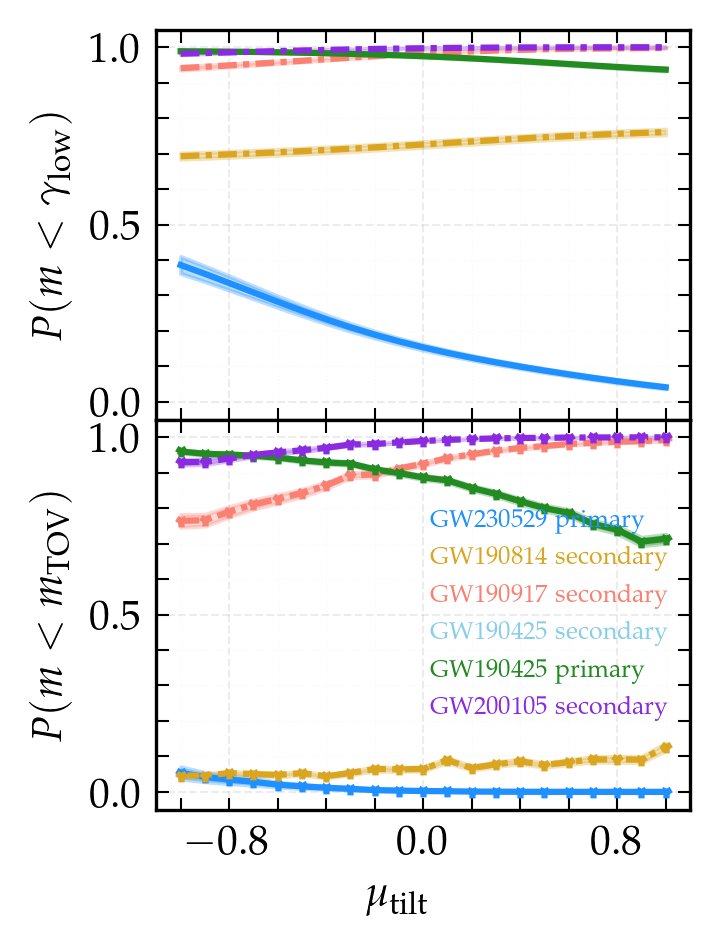

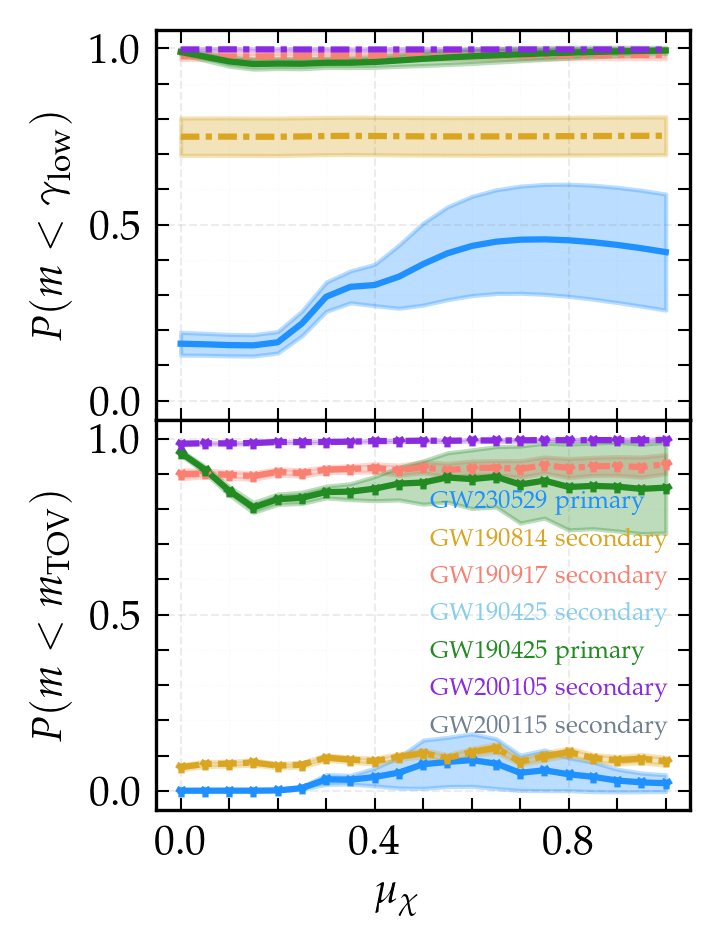

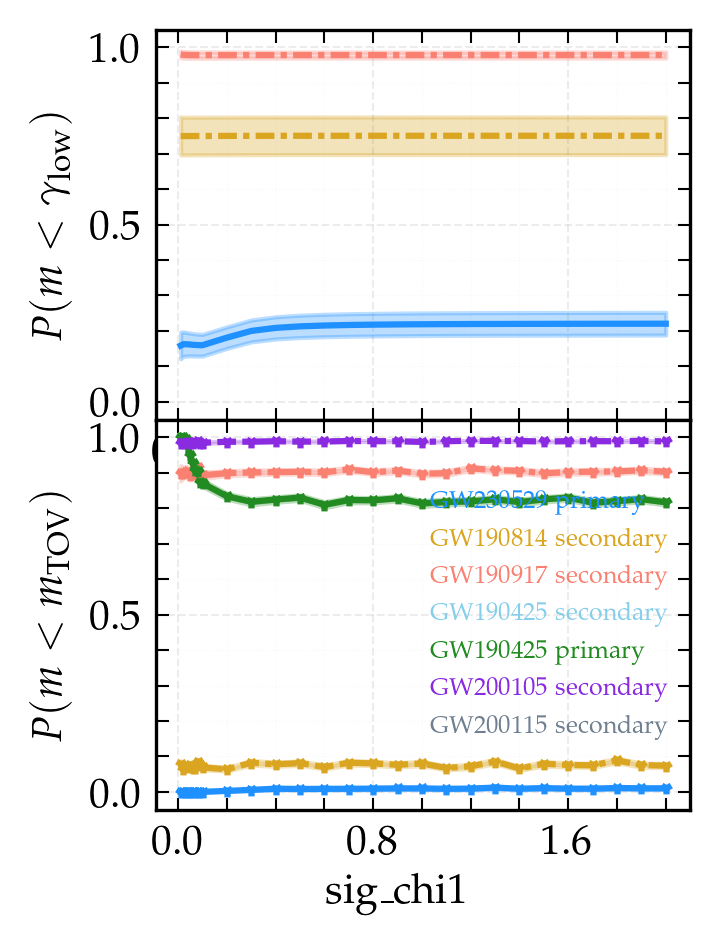

In [9]:
item = "mu_cos_tilt"
exclude_events = ["GW200105_1", "GW190917_1", "GW200115_2"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

item = "mu_chi1"
exclude_events = ["GW200105_1", "GW190917_1"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

item = "sigma_chi"
exclude_events = ["GW200105_1", "GW190917_1"]
# exclude_events=[]
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig(f"plots/pop_grid_eos_{item}.png", dpi = 300)

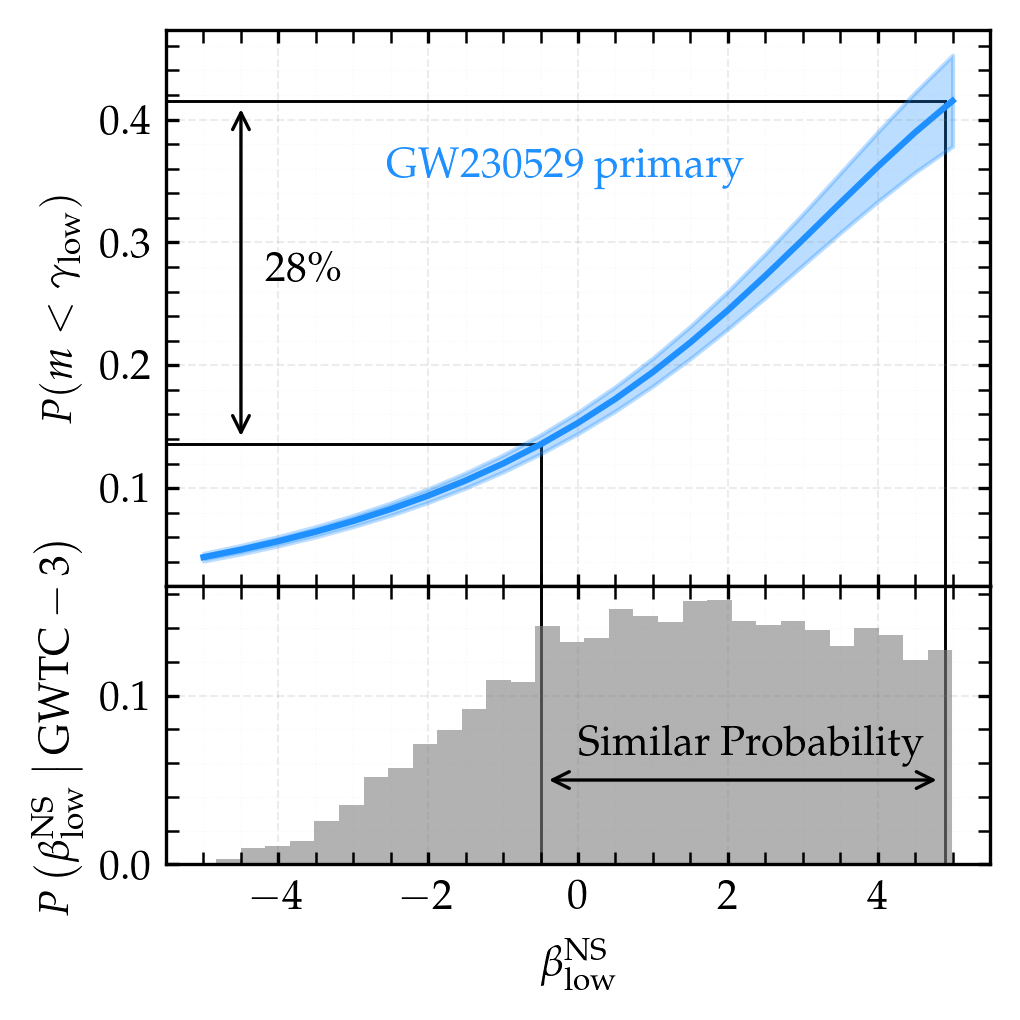

In [10]:
def plot_compare_hyperposterior_prob_NS(df_pop, pop_parameter, exclude_events = []):
    pop_GW190917_m1 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190917_m2 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW230529_m1 = df_pop[(df_pop['event'] == "GW230529") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190814_m2 = df_pop[(df_pop['event'] == "GW190814") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m1 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m2 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m1 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m2 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200115_m2 = df_pop[(df_pop['event'] == "GW200115") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_objects_lst = [pop_GW230529_m1, pop_GW190814_m2, pop_GW190917_m2, pop_GW190917_m1, pop_GW190425_m2, pop_GW190425_m1, pop_GW200105_m2, pop_GW200105_m1, pop_GW200115_m2]
    pop_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    pop_objects_colors = [event_component_colors[name_to_key(name)] for name in pop_objects_names]
    
    exclude_labels = set(key_to_name(e) for e in exclude_events)
    
    pop_keep_idxs = [i for i, name in enumerate(pop_objects_names) if name not in exclude_labels]
    pop_objects_lst = [pop_objects_lst[i] for i in pop_keep_idxs]
    pop_objects_names = [pop_objects_names[i] for i in pop_keep_idxs]
    pop_objects_colors = [pop_objects_colors[i] for i in pop_keep_idxs]

    run = "multiPDB_betaSplit3_brokenG" 
    filename = f"../conversion_scripts/{run}/population.csv.gz"
    population_run_df = pd.read_csv(filename, compression='gzip')
    samples = population_run_df.to_dict(orient="list")

    with open(f"../conversion_scripts/{run}/conversion_dict_inv.json", 'r') as f:
        conv_dict = json.load(f)

    parameter = conv_dict[pop_parameter]
    param_samples = samples[conv_dict[pop_parameter]]

    # === Gridspec layout with shared x-axis ==
    TEXT_SIZE = 10
    fig = plt.figure(figsize=(3.5, 3.5), dpi=300)
    # Gridspec layout
    gs  = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.00)
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1], sharex=ax0)

    # Plot each object
    for i, curr in enumerate(pop_objects_lst):
        color = pop_objects_colors[i]
        name = pop_objects_names[i]
        p05 = curr["probability"] - 1.28 * curr["prob_error"]
        p95 = curr["probability"] + 1.28 * curr["prob_error"]
        
        ax0.plot(curr[pop_parameter], curr["probability"], color=color, zorder=0)
        ax0.fill_between(curr[pop_parameter], p05, p95, color=color, alpha=0.3, zorder=0)

    legend_elements_pop = [
    Line2D([0], [0], label=label, color='none')
    for label in pop_objects_names
    ]
    legend = ax0.legend(handles=legend_elements_pop, loc='center left', fontsize=TEXT_SIZE, bbox_to_anchor=(0.08, 0.75), frameon=False)
    for text, color in zip(legend.get_texts(), pop_objects_colors):
        text.set_color(color)

    # Axis styling
    lab = r"$P(m < \gamma_{\mathrm{low}})$"
    ax0.set_ylabel(lab, fontsize=TEXT_SIZE)
    # ax0.tick_params(axis='both', direction='in', which='both', top=True, right=True, length=3)
    # ax0.yaxis.set_major_locator(plt.MaxNLocator(nbins=6, prune=None))


    for ax in [ax0, ax1]:
        ax.minorticks_on()
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.15)
        ax.grid(which='minor', axis='both', color='gray', linestyle=':', linewidth=0.3, alpha=0.05)

    # Histogram below
    ax1.hist(param_samples, bins=30, density=True, color="grey", alpha = 0.6)  # More bins for detail


    #########
    # Choose x0 and y0: the target point on the top plot
    x1 = 4.9
    y1_data = pop_GW230529_m1["probability"].iloc[np.argmin(np.abs(pop_GW230529_m1[pop_parameter].values - x1))]
    ymin, ymax = ax0.get_ylim() ; xmin, xmax = ax0.get_xlim()
    y1_frac = (y1_data - ymin) / (ymax - ymin) ; x1_frac = (x1 - xmin) / (xmax - xmin)
    ax0.axvline(x=x1, ymax=y1_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax0.axhline(y=y1_data, xmax=x1_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax1.axvline(x=x1, color='black', linestyle='-', linewidth=0.7, zorder=-1)

    x0 = -0.5
    y0_data = pop_GW230529_m1["probability"].iloc[np.argmin(np.abs(pop_GW230529_m1[pop_parameter].values - x0))]
    ymin, ymax = ax0.get_ylim() ; xmin, xmax = ax0.get_xlim()
    y0_frac = (y0_data - ymin) / (ymax - ymin) ; x0_frac = (x0 - xmin) / (xmax - xmin)
    ax0.axvline(x=x0, ymax=y0_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax0.axhline(y=y0_data, xmax=x0_frac, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    ax1.axvline(x=x0, color='black', linestyle='-', linewidth=0.7, zorder=-1)
    #########

    # X label with LaTeX if available
    if pop_parameter in pop_parameter2latex:
        pop_lab = rf'{pop_parameter2latex[pop_parameter]}' 
    else:
        pop_lab = f"{pop_parameter}"



    ax1.set_xlabel(pop_lab, fontsize=TEXT_SIZE)
    # ax1.set_ylabel(f"P({pop_lab}"r"$\mid$GWTC-3.0)", fontsize=TEXT_SIZE)
    pop_lab_math = pop_lab.strip("$")  # e.g. "$\\beta_{\\mathrm{low}}^\\mathrm{NS}$" -> "\beta_{\mathrm{low}}^\mathrm{NS}"
    ax1.set_ylabel(
        rf"$P\left({pop_lab_math}\,\middle|\,\mathrm{{GWTC}}-3\right)$",
        fontsize=TEXT_SIZE
    )

    for ax in [ax0, ax1]:
        ax.tick_params(axis='both', direction='in', which='both', top=True, right=True, length=3)


    x_left = x0
    x_right = x1
    y_arrow = 0.05      # vertical position of arrow in data coords; adjust to stay low

    ax1.annotate(
        '',
        xy=(x_right, y_arrow),
        xytext=(x_left, y_arrow),
        arrowprops=dict(arrowstyle='<->', color='black', linewidth=0.8),
        annotation_clip=False
    )

    # Vertical arrow spanning some range on ax0
    y_bot = y0_data   # start of arrow (lower end)
    y_top = y1_data   # end of arrow (upper end)
    x_arrow = x0 - 4     # slight offset so it doesn't lie directly on the vertical line

    ax0.annotate(
        '',
        xy=(x_arrow, y_top),
        xytext=(x_arrow, y_bot),
        arrowprops=dict(arrowstyle='<->', color='black', linewidth=0.8),
        annotation_clip=False
    )

    ax0.text(
        0.12, 0.60,  # x, y in axes fraction (0 to 1)
        f"~ {100*abs(y0_data-y1_data):.0f}\%",
        transform=ax0.transAxes,
        fontsize=TEXT_SIZE,
        verticalalignment='top',
        horizontalalignment='left'
    )

    ax1.text(
    0.5, 0.5,  # x, y in axes fraction (0 to 1)
    "Similar Probability",
    transform=ax1.transAxes,
    fontsize=TEXT_SIZE,
    verticalalignment='top',
    horizontalalignment='left'
    )

    # Hide top ticks of lower plot
    plt.setp(ax0.get_xticklabels(), visible=False)

    # Adjust spacing and layout
    plt.subplots_adjust(hspace=0.00)
    plt.tight_layout()


item = "beta_low_NS"
exclude_events = ["GW200105_1", "GW200105_2", "GW200115_2", "GW190425_2", "GW190917_1", "GW190917_2", "GW190814_2", "GW190425_1"]
plot_compare_hyperposterior_prob_NS(results[item], folder2pop_parameter[item], exclude_events=exclude_events)
plt.savefig("plots/hyperposterior_PNS_comparison.png", dpi=300)

In [11]:
from conversion_cosmology import Cosmology
import sys
import json
import pandas as pd
from matplotlib.lines import Line2D

try:
    sys.path.insert(0, "../../sampler/runs/multiPDB_betaSplit3_brokenG_1_full/")
    from model_vector import model_vector
except:
    sys.path.append("../../sampler/runs/multiPDB_betaSplit3_brokenG_1_full/")
    from sampler.runs.multiPDB_betaSplit3_brokenG_1_full.model_vector import model_vector 

path = "../conversion_scripts/multiPDB_betaSplit3_brokenG/conversion_dict_inv.json"

with open(path, "r") as f:
    conv = json.load(f)

conv["w"] = "w"
PLANCK_2018_Ho = 2.1816926176539463e-18 ### CGS
PLANCK_2018_OmegaMatter = 0.3158
PLANCK_2018_OmegaLambda = 1. - PLANCK_2018_OmegaMatter
PLANCK_2018_OmegaRadiation = 0.

### define units in SI
C_SI =  299792458.0
PC_SI = 3.085677581491367e+16
MPC_SI = PC_SI * 1e6
G_SI = 6.6743e-11
MSUN_SI = 1.9884099021470415e+30

### define units in CGS
G_CGS = G_SI * 1e+3
C_CGS = C_SI * 1e2
PC_CGS = PC_SI * 1e2
MPC_CGS = MPC_SI * 1e2

event_samples = pd.read_csv("../samples/GW230529_Combined_PHM_highSpin.csv.gz")
population_samples = pd.read_csv(f"../grid_beta_low_NS/population4.0.csv.gz")
# population_samples = pd.read_csv("../grid_gamma_low_debug/Farah2022-i-PDB.csv.gz")

requirements = [
    'm_break', 'alpha_1', 'alpha_2', 'gamma_low', 'eta_low', 'gamma_high', 'eta_high', 'A',
    'm_min', 'eta_min', 'm_max', 'eta_max',
    'mu_peak1', 'sig_peak1', 'peak_constant1',
    'mu_peak2', 'sig_peak2', 'peak_constant2',
    'model_min', 'model_max',
    'beta_1', 'beta_2', 'beta_gap', 'sep',
    'H0', 'Om0', 'w', 'kappa',
    'mu_chi1', 'sig_chi1', 'mix_tilt1', 'sig_tilt1',
    'mu_chi2', 'sig_chi2', 'mix_tilt2', 'sig_tilt2',
    'm_spin_break', 'a_min', 'a_max',
    'costilt_max', 'costilt_min', 'a_max_NS'
]
event_samples["chi_eff"] = (event_samples['mass1_source'] * event_samples['spin1_magnitude'] * np.cos(event_samples['spin1_polar_angle']) +
                                 event_samples['mass2_source'] * event_samples['spin2_magnitude'] * np.cos(event_samples['spin2_polar_angle'])) / \
                                 (event_samples['mass1_source'] + event_samples['mass2_source'])

conv_dict = {"mass1_source":"mass1_source","mass2_source": "mass2_source","redshift":"z","a_1":"spin1_magnitude","tilt1": "spin1_polar_angle","a_2":"spin2_magnitude","tilt2":"spin2_polar_angle"}

_pe = lambda x: event_samples[conv_dict[x]].values.T
costilt1 = np.cos(_pe("tilt1")) ; costilt2 = np.cos(_pe("tilt2"))
z = _pe("redshift") ; a1 = _pe("a_1") ; a2 = _pe("a_2")
theta_pe = np.array([_pe("mass1_source"), _pe("mass2_source"), z, a1, costilt1, a2, costilt2])
theta_pe = np.expand_dims(theta_pe, axis = 2)

lnprob_mass1_source = np.log(1 + _pe('redshift'))
lnprob_mass2_source = np.log(1 + _pe('redshift'))
importance_pe = np.zeros((len(event_samples), 1))  # Initialize importance_pe with zeros

change_vals = [-0.5, 4.9]
num_hyperpost = int(len(population_samples["notch_lowmass_scale"])/1) # len(lambda_pop)
num_events = 1
num_dim = 7

mass2_source_arr = np.zeros((len(change_vals), num_hyperpost))
mass1_source_arr = np.zeros((len(change_vals), num_hyperpost))
a1_arr = np.zeros((len(change_vals), num_hyperpost))
costilt1_arr = np.zeros((len(change_vals), num_hyperpost))
a2_arr = np.zeros((len(change_vals), num_hyperpost))
costilt2_arr = np.zeros((len(change_vals), num_hyperpost))

for i in tqdm(range(len(change_vals))):
    # population_samples = pd.read_csv(f"../grid_beta_low/population{change_vals[i]}.csv.gz") #debugging purposes only
    population_samples["w"] = np.ones(len(population_samples)) * -1.0  # Set w to -1.0 for all samples
    population_samples[conv["beta_1"]] = np.ones(len(population_samples)) * change_vals[i]
    lambda_pop = population_samples[[conv[param] for param in requirements]]
    reweighed_samples = np.empty((num_hyperpost, num_events, num_dim))

    for k in range(num_hyperpost):
        weights = np.exp(model_vector(theta_pe, lambda_pop.T[k]) - importance_pe)
        for j in range(num_events):
            index = np.random.choice(len(weights), p=weights.squeeze() / weights.squeeze().sum())
            reweighed_samples[k, j, :] = theta_pe[:, index, j]

    mass1_source, mass2_source, redshift, a1, costilt1, a2, costilt2 = reweighed_samples.squeeze().T
    mass2_source_arr[i] = mass2_source
    mass1_source_arr[i] = mass1_source
    a1_arr[i] = a1
    costilt1_arr[i] = costilt1
    a2_arr[i] = a2
    costilt2_arr[i] = costilt2


mass_ratio_arr = mass2_source_arr / mass1_source_arr
chi_eff_arr = (mass1_source_arr*a1_arr*(costilt1_arr) + mass2_source_arr*a2_arr*costilt2_arr)/(mass1_source_arr + mass2_source_arr)

100%|██████████| 2/2 [02:53<00:00, 86.76s/it]


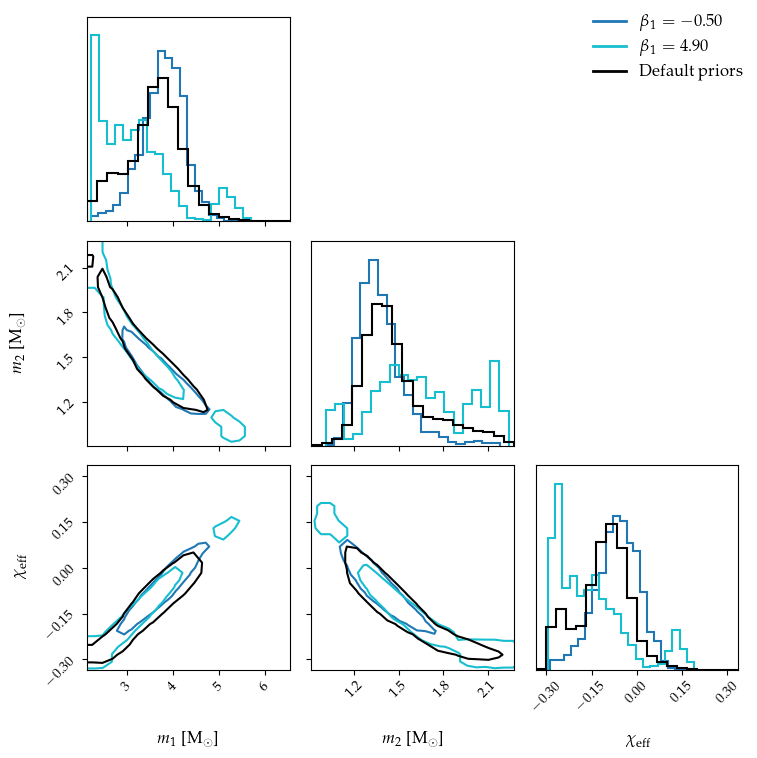

In [12]:
cred = 0.9

num_betas = mass1_source_arr.shape[0]
corner_labels = [r'$m_1$ [M$_\odot$]', r'$m_2$ [M$_\odot$]', r'$\chi_{\mathrm{eff}}$']
colors = plt.cm.tab10(np.linspace(0, 1, num_betas))
corner_fig = None

# Plot your colored datasets with KDE smoothing
for i in range(num_betas):
    corner_params = np.array([
        mass1_source_arr[i],
        mass2_source_arr[i],
        chi_eff_arr[i]
    ])

    corner_fig = corner.corner(
        corner_params.T,
        fig=corner_fig,
        labels=corner_labels if i == 0 else None,
        show_titles=False,
        label_kwargs={"fontsize": 12},
        plot_density=False,
        plot_datapoints=False,
        hist_kwargs={"histtype": "step", "density": True, "color": colors[i], "linewidth": 1.5},
        plot_contours=True,
        fill_contours=False,
        levels=[cred],
        contour_kwargs={'colors': [colors[i]], 'linewidths': 1.5},
        smooth=0.5
    )

# Now plot the Default priors dataset in black, smoothed KDE
default_params = np.array([
    event_samples["mass1_source"],
    event_samples["mass2_source"],
    event_samples["chi_eff"]
])

corner_fig = corner.corner(
    default_params.T,
    fig=corner_fig,
    labels=corner_labels,
    show_titles=False,
    label_kwargs={"fontsize": 12},
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={"histtype": "step", "density": True, "color": "black", "linewidth": 1.5},
    plot_contours=True,
    fill_contours=False,
    levels=[cred],
    contour_kwargs={'colors': ['black'], 'linewidths': 1.5},
    smooth=0.5
)

# Legend with colors + black for Default priors
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=2, label=fr'$\beta_1 = {change_vals[i]:.2f}$')
    for i in range(num_betas)
] + [Line2D([0], [0], color='black', lw=2, label='Default priors')]

corner_fig.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.show()

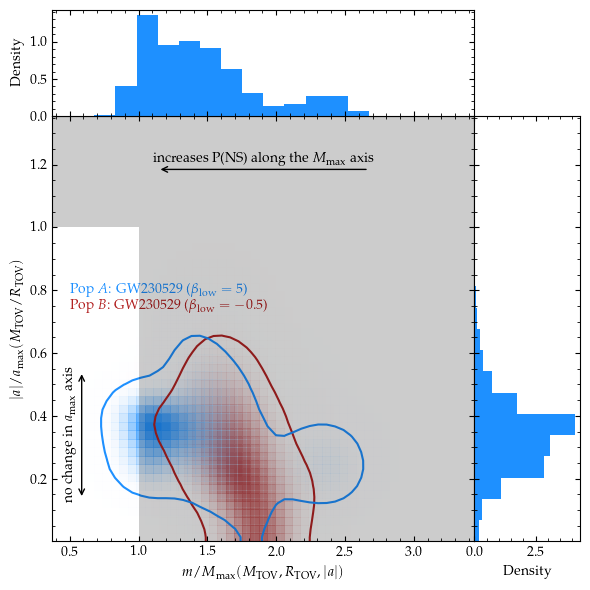

In [47]:
# Load data

EVENT_COLOR = event_component_colors["GW230529_1"]
TEXT_SIZE = 10

pop_param_A = 5
pop_param_B = -0.5
number = 230529

df = np.load(f"reproduce_mmms-plot-mass-spin/mmms_mass_spin_weights_{number}_beta1{pop_param_A}.npz")
x = df["mass_ratio"]
y = df["spin_ratio"]
weights = df["sample_weights"]

df2 = np.load(f"reproduce_mmms-plot-mass-spin/mmms_mass_spin_weights_{number}_beta1{pop_param_B}.npz")
x2 = df2["mass_ratio"]
y2 = df2["spin_ratio"]
weights2 = df2["sample_weights"]

# Labels
xlab = '$m/M_\\mathrm{max}(M_\\mathrm{TOV}, R_\\mathrm{TOV}, |a|)$'
ylab = '$|a|/a_\\mathrm{max}(M_\\mathrm{TOV}/R_\\mathrm{TOV})$'

# Create figure with GridSpec
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.0, wspace=0.0)

# Lower left: 2D histogram (scatter with contour style)
# Plot contour
ax_main = fig.add_subplot(gs[1, 0])
corner.hist2d(x2, y2, weights=weights2, bins=50, plot_datapoints=False,
              plot_contours=True, no_fill_contours=True,
              smooth=2, ax=ax_main, color='firebrick', levels=[0.9])
corner.hist2d(x, y, weights=weights, bins=50, plot_datapoints=False,
              plot_contours=True, no_fill_contours=True,
              smooth=2, ax=ax_main, color=EVENT_COLOR, levels = [0.9])

ax_main.set_xlabel(xlab, fontsize=TEXT_SIZE)
ax_main.set_ylabel(ylab, fontsize=TEXT_SIZE)


# Get axis limits
x0, x1 = ax_main.get_xlim()
y0, y1 = ax_main.get_ylim()

# Normalize the cutoff points relative to axis limits
y_norm_1 = (1 - y0) / (y1 - y0)  # normalized y=1
x_norm_1 = (1 - x0) / (x1 - x0)  # normalized x=1

# Shade region x > 1, but only up to y=1 (vertically limited)
ax_main.axvspan(
    1, x1,             # data coords on x-axis
    ymin=0,            # from bottom of plot
    ymax=y_norm_1,     # up to y=1 normalized height
    facecolor='black',
    alpha=0.2,
    edgecolor='none',
    zorder=10
)

# Shade region y > 1, but only up to x=1 (horizontally limited)
ax_main.axhspan(
    1, y1,             # data coords on y-axis
    # xmin=0,            # from left edge of plot
    # xmax=x_norm_1,     # up to x=1 normalized width
    facecolor='black',
    alpha=0.2,
    edgecolor='none',
    zorder=10
)




# Bottom right: Y histogram
ax_yhist = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_yhist.hist(y, bins=20, orientation='horizontal', weights=weights, color=EVENT_COLOR, density=True)
ax_yhist.tick_params(labelleft=False)
ax_yhist.set_xlabel("Density", fontsize=TEXT_SIZE)

# Top left: X histogram
ax_xhist = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_xhist.hist(x, bins=20, weights=weights, color=EVENT_COLOR, density=True)
ax_xhist.tick_params(labelbottom=False)
ax_xhist.set_ylabel("Density", fontsize=TEXT_SIZE)

# Set minor ticks on and tick direction inwards for all axes
for ax in [ax_main, ax_xhist, ax_yhist]:
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)

X = 0.5
Y = 0.8

ax_main.text(X, Y, rf"Pop $A$: GW{number} ($\beta_{{\mathrm{{low}}}} = {pop_param_A}$)", color=EVENT_COLOR, ha='left', va='center', fontsize=TEXT_SIZE)

ax_main.text(X, Y - 0.05, rf"Pop $B$: GW{number} ($\beta_{{\mathrm{{low}}}} = {pop_param_B}$)", color='firebrick', ha='left', va='center', fontsize=TEXT_SIZE)

# ax_main.set_ylim(0, 0.7)

# Top right is empty
fig.add_subplot(gs[0, 1]).axis('off')

Y = -0.5
ax_xhist.annotate(
    '', 
    xy=(0.75, Y), xycoords='axes fraction',
    xytext=(0.25, Y), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='<-', color='black', linewidth=1),
    annotation_clip=False
)

# Label for the arrow
ax_xhist.text(
    0.5, Y+0.03,  # x, y in axes fraction
    "increases P(NS) along the "r"$M_{\mathrm{max}}$ axis",
    transform=ax_xhist.transAxes,
    fontsize=TEXT_SIZE,
    ha='center', va='bottom'
)


# Coordinates in axes fraction for lower-left placement
X = 0.07
Y0 = 0.10
Y1 = Y0+0.3

# Vertical double-headed arrow
ax_main.annotate(
    '',
    xy=(X, Y1), xytext=(X, Y0),
    xycoords='axes fraction', textcoords='axes fraction',
    arrowprops=dict(arrowstyle='<->', color='black', linewidth=1),
    annotation_clip=False
)

# Rotated label aligned with the arrow
ax_main.text(
    X - 0.03, (Y0 + Y1) / 2,
    r"no change in $a_{\mathrm{max}}$ axis",
    transform=ax_main.transAxes,
    fontsize=TEXT_SIZE,
    rotation=90,
    ha='center', va='center'
)

# Save and show
plt.savefig(f"plots/mmms-mass-spin_beta1_GW{number}.png", dpi = 300)
plt.show()
